In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
import joblib
import warnings

sns.set_context("notebook", font_scale=1.2)
warnings.filterwarnings('ignore')

RAW_DATA_PATH = '../data/raw/raw_solves.csv'
PROCESSED_DATA_PATH = '../data/processed/rubiks_times_series.csv'
MODEL_PATH = '../models/hmm_gaussian.pkl'
SCALER_PATH = '../models/hmm_scaler.pkl'

In [134]:
df = pd.read_csv(RAW_DATA_PATH, sep=';')
df.columns = df.columns.str.strip()

df = df[['Time', 'Date']].copy()
df.columns = ['time_sec', 'timestamp']

df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

df['time_sec'] = pd.to_numeric(df['time_sec'], errors='coerce')
df = df.dropna().reset_index(drop=True)

In [135]:
df['volatility_5'] = df['time_sec'].rolling(window=5, min_periods=5).std()
df_clean = df.dropna().reset_index(drop=True)

features = ['time_sec', 'volatility_5']
X_raw = df_clean[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

df_clean['z_time'] = X_scaled[:, 0]
df_clean['z_vol'] = X_scaled[:, 1]

if X_scaled.shape[1] != 2:
    raise ValueError(f"CRITICAL ERROR: Data has {X_scaled.shape[1]} columns. Expected 2.")

In [136]:
hmm = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000, random_state=42)
hmm.fit(X_scaled)

total_variance = np.sum(hmm.covars_, axis=1)
order = np.argsort(total_variance)

hmm.startprob_ = hmm.startprob_[order]
hmm.transmat_ = hmm.transmat_[order, :][:, order]
hmm.means_ = hmm.means_[order]
hmm._covars_ = hmm.covars_[order]

sorted_hmm = hmm

In [137]:
hmm = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000, random_state=42)
hmm.fit(X_scaled)

variances = np.sum(hmm._covars_, axis=1)
order = np.argsort(variances)

def reorder_matrix(matrix, order):
    return matrix[order, :][:, order]

new_means = hmm.means_[order]
new_covars = hmm.covars_[order]
new_starts = hmm.startprob_[order]
new_transmat = reorder_matrix(hmm.transmat_, order)

hmm._means_ = new_means
hmm._covars_ = new_covars
hmm._startprob_ = new_starts
hmm._transmat_ = new_transmat

sorted_hmm = hmm

In [138]:
hmm = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000, random_state=42)
hmm.fit(X_scaled)

total_variance = np.sum(hmm._covars_, axis=1)
order = np.argsort(total_variance)


def reorder_matrix(matrix, order):
    return matrix[order, :][:, order]

hmm.means_ = hmm.means_[order]
hmm.startprob_ = hmm.startprob_[order]
hmm.transmat_ = reorder_matrix(hmm.transmat_, order)

hmm._covars_ = hmm._covars_[order] 

sorted_hmm = hmm

print(f"State 0 (Flow) Means: {sorted_hmm.means_[0]}")
print(f"State 2 (Tilt) Means: {sorted_hmm.means_[2]}")

State 0 (Flow) Means: [-0.08670075 -0.56250335]
State 2 (Tilt) Means: [0.2082397  0.98659028]


In [139]:
hidden_states = sorted_hmm.predict(X_scaled)
posterior_probs = sorted_hmm.predict_proba(X_scaled)

df_clean['state_id'] = hidden_states
df_clean['state_name'] = df_clean['state_id'].map({0: 'Flow', 1: 'Baseline', 2: 'Tilt'})

df_clean['prob_flow'] = posterior_probs[:, 0]
df_clean['prob_base'] = posterior_probs[:, 1]
df_clean['prob_tilt'] = posterior_probs[:, 2]

df_clean.head()

,time_sec,timestamp,volatility_5,z_time,z_vol,state_id,state_name,prob_flow,prob_base,prob_tilt
0,16.88,2025-10-25 20:57:25,1.996292,-0.518468,-0.725748,1,Baseline,0.000024,0.999976,7.565706e-71
1,17.30,2025-10-25 20:58:08,2.324754,-0.382014,-0.428429,0,Flow,0.999924,0.000030,4.602581e-05
2,13.93,2025-10-25 20:58:49,2.904646,-1.476902,0.096480,2,Tilt,0.000078,0.410234,5.896883e-01
3,22.50,2025-10-25 20:59:34,3.332676,1.307428,0.483926,2,Tilt,0.418094,0.000345,5.815608e-01
4,18.13,2025-10-25 21:00:38,3.092680,-0.112353,0.266685,2,Tilt,0.030583,0.319689,6.497286e-01


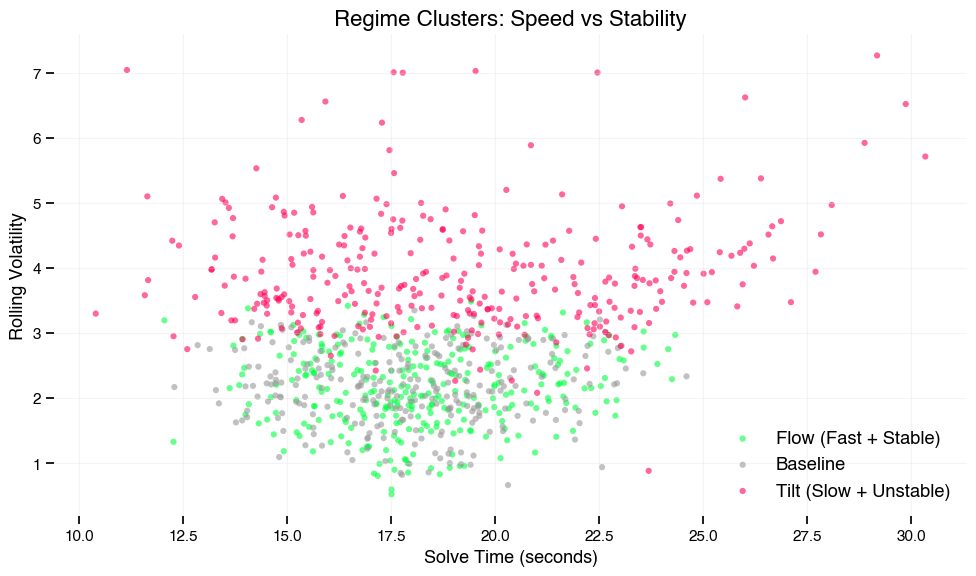

In [140]:
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.grid": True,
    "grid.color": "#DDDDDD",
    "grid.alpha": 0.30,
    "grid.linewidth": 0.8,
    "axes.titlesize": 16,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "font.family": "Helvetica",
})

FLOW_COLOR  = "#00FF41"
BASE_COLOR  = "#999999"
TILT_COLOR  = "#FF0055"

plt.figure()

colors = [FLOW_COLOR, BASE_COLOR, TILT_COLOR]
labels = ['Flow (Fast + Stable)', 'Baseline', 'Tilt (Slow + Unstable)']

for i in range(3):
    subset = df_clean[df_clean['state_id'] == i]
    plt.scatter(
        subset['time_sec'],
        subset['volatility_5'],
        s=20,
        alpha=0.6,
        c=colors[i],
        label=labels[i],
        edgecolors="none"
    )

plt.title("Regime Clusters: Speed vs Stability")
plt.xlabel("Solve Time (seconds)")
plt.ylabel("Rolling Volatility")

plt.legend(frameon=False)
plt.tight_layout()
plt.show()


In [ ]:
df_clean.to_csv(PROCESSED_DATA_PATH, index=False)

joblib.dump(sorted_hmm, MODEL_PATH)

joblib.dump(scaler, SCALER_PATH)

['../models/hmm_scaler.pkl']